# Homework of Week 9

In [22]:
# Uninstall first to avoid conflicts
#!pip uninstall -y qiskit qiskit-aer qiskit-algorithms

# Install core Qiskit and the simulator
# !pip install qiskit==1.3.2 qiskit-aer==0.13.2 qiskit-algorithms==0.3.1

In [23]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [24]:
# Versions
import qiskit
import qiskit_algorithms

print(f"Qiskit version {qiskit.__version__}")
print(f"Qiskit algorithms version {qiskit_algorithms.__version__}")


# Quantum Circuits!
from qiskit import QuantumCircuit

# General Imports
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService

# Run time-evolution problems
from qiskit_algorithms.time_evolvers import TrotterQRTE, TimeEvolutionProblem

Qiskit version 1.3.2
Qiskit algorithms version 0.3.1


# Auxiliary Code

In [25]:
# Calculate the pauli inverse matrix that we can apply on any matrix to get the coefficients of its Pauli expantion
def pauliinv(n: int) -> tuple[list, list, np.ndarray]:

    # Make sure n is a power of 2
    if not np.allclose(int(np.log2(n)), np.log2(n)):
        raise ValueError("The parameter n must be a power of 2.")

    # Define Pauli matrices
    si = np.array([[1, 0], [0, 1]])
    sx = np.array([[0, 1], [1, 0]])
    sy = np.array([[0, -1j], [1j, 0]])
    sz = np.array([[1, 0], [0, -1]])
    pp2 = [si, sx, sy, sz]
    ll2 = ["I", "X", "Y", "Z"]

    # Compute the higher-order pauli matrices and labels
    ppn = list(np.copy(pp2))
    lln = list(np.copy(ll2))
    for _ in range(int(np.log2(n)) - 1):
        ppn = [np.kron(s1, s2) for s1 in ppn for s2 in pp2]
        lln = [s1 + s2 for s1 in lln for s2 in ll2]

    # Compute the coefficients matrix for the equation a0 * si + a1 * sx + a2 * sy + a3 * sz = M where M is a matrix
    coeffn = np.array([list(ss.flatten()) for ss in ppn], dtype=np.complex128).T
    paulin = np.linalg.inv(coeffn)

    return lln, ppn, paulin


# Pre-compute some matrices
ll2, pp2, pauli2 = pauliinv(2)
ll4, pp4, pauli4 = pauliinv(4)

In [26]:
def bloch_from_state(state: list) -> list:
    # Get phases
    phi0 = np.angle(state[0])
    phi1 = np.angle(state[1])

    # Get angles
    theta = 2 * np.arccos(np.abs(state[0]))
    phi = phi1 - phi0

    return [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]

In [27]:
def plotVector(vv: np.ndarray, title: str, R: float = 0.99):
    # Create a meshgrid with angular variables
    u, v = np.meshgrid(np.linspace(0, 2 * np.pi, 30), np.linspace(0, np.pi, 20))

    # Convert spherical coordinates to Cartesian
    x = R * np.cos(u) * np.sin(v)
    y = R * np.sin(u) * np.sin(v)
    z = R * np.cos(v)

    # Create 3D figure
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot wireframe
    ax.plot_surface(x, y, z, color='b', alpha=0.05)
    ax.plot_wireframe(x, y, z, color='b', alpha=0.05)

    # Get vector coordinates
    vx = vv[:, 0]
    vy = vv[:, 1]
    vz = vv[:, 2]

    # Now we can visualize the evolution of the magnetic polarization by plotting the polar and azimuthal angles over time
    ax.plot(vx, vy, vz, color='g')
    ax.quiver(0, 0, 0, vx[0], vy[0], vz[0], color='b')
    ax.quiver(0, 0, 0, vx[-1], vy[-1], vz[-1], color='r')

    # Labeling
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.title(title)
    plt.show()

    print("Blue Arrow: Initial State")
    print("Red Arrow: Final State")

    return

In [28]:
def aersim(qc: QuantumCircuit, shots: int = 1024, noise: None | NoiseModel = None) -> dict:
    # Create noisy simulator backend
    if noise:
        sim = AerSimulator(noise_model=noise)
    else:
        sim = AerSimulator()

    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(
        optimization_level=3, backend=sim
    )
    qc = passmanager.run(qc)

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return counts

# Quantum Oscillator

In [29]:
# Initializing a two-qubit quantum state
instate = [
    1/np.sqrt(2)+0.j,
    1/np.sqrt(2)+0.j,
    0,
    0
]
instate = Statevector(instate)

# Constructing the Hamiltonian (in Qiskit operator form)
ham = np.array([
    [0.5,0,0,0],
    [0,1.5,0,0],
    [0,0,2.5,0],
    [0,0,0,3.5]
])

# Decompose the Hamiltonian into Pauli matrices
coeffs = pauli4 @ ham.flatten()

# Create SparsePauliOp
ham_pauli = SparsePauliOp.from_list(list(zip(ll4, coeffs)))

# Make sure our Pauli Operator matches the real Hamiltonian
print(f"Using correct Hamiltonian: {'Yes' if np.allclose(ham_pauli.to_matrix(), np.array(ham)) else 'No'}")

Using correct Hamiltonian: Yes


## Exercise 1 - Simulate a Given Initial State

We consider the following initial condition:

$$
\vert {\psi}_\text{sim}\rangle = \frac{1}{\sqrt{2}} \left(\ket{{00}_\text{sim}} + \ket{{01}_\text{sim}} \right).
$$

Now we:
- Use units of time are $\omega^{-1}$.
- Simulate the effect of the Hamiltonian using Trotterization.
- Compute the Bloch vector of the first qubit, because this is an eigenstate of the Hamiltonian, hence the components where the second qubit is $\ket 1$ will always have a coefficient of zero.

The average probability for the first qubit to be in state |1> is 9.630e-32%.


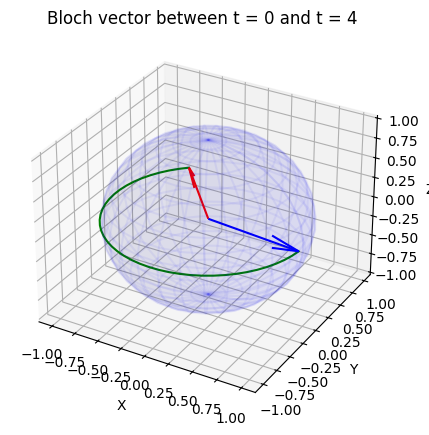

Blue Arrow: Initial State
Red Arrow: Final State


Z Component of Bloch vector has average -7.381e-16 and std 3.323e-16


In [30]:
# Parameters
tfinal = 4
tsteps = 40

# Using this tutorial: https://qiskit-community.github.io/qiskit-algorithms/tutorials/13_trotterQRTE.html
tt = np.linspace(0, tfinal, tsteps + 1)
oo = []
for tf in tt[1:]:
    problem = TimeEvolutionProblem(ham_pauli, initial_state=instate, time=tf)

    # Do the time evolution
    trotter = TrotterQRTE()
    result = trotter.evolve(problem)

    # Get the result
    oo += [Statevector(result.evolved_state)]

# Average component for the first qubit in state |1>
print(f"The average probability for the first qubit to be in state |1> is {100 * np.average([np.abs(outstate[2])**2 + np.abs(outstate[3])**2 for outstate in oo]):.3e}%.")

oo = np.array([bloch_from_state([outstate[0], outstate[1]]) for outstate in oo])

plotVector(oo, f"Bloch vector between t = {0} and t = {tfinal}")
print("\n")
print(f"Z Component of Bloch vector has average {np.average(oo[:, 2]):.3e} and std {np.std(oo[:, 2]):.3e}")

## Exercise 2 - Run on IBM Computer

We run with the **noise model** of a IBM computer, but we still use a simulator.

We observe that now there is a significant proportion of measurements for states which are orthogonal to our initial state, as a consequence of the noise associated with gates in a real quantum computer.

backend.name ='ibm_sherbrooke', backend.num_qubits = 127


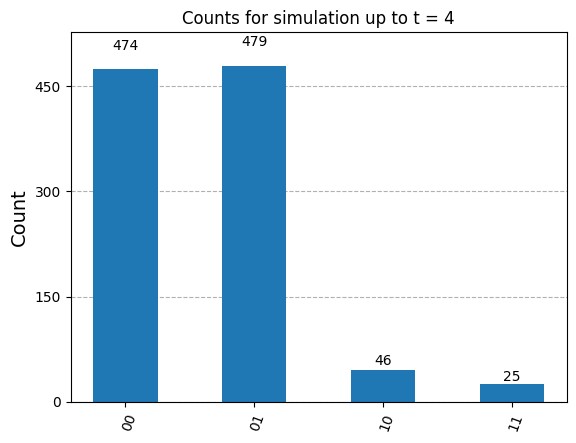

In [31]:
# Initiate connection
TOKEN = "11cf40c4938ae90a81c46fcb5fba785e229c640a57f2b23d8e836f37f3de2d7abc2bc176c0742bbb3e85cf937774a89db0630913240faf5e82b2d63e9654ff16"
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

# Choose a real quantum computer, which is not busy
backend = service.least_busy(operational=True, simulator=False)
print(f"{backend.name =}, {backend.num_qubits = }")

# Get noise profile
noise_real = NoiseModel.from_backend(backend)

# Same procedure as above
problem = TimeEvolutionProblem(ham_pauli, initial_state=instate, time=tfinal)

# Do the time evolution
trotter = TrotterQRTE()
result = trotter.evolve(problem)

# Get the quantum circuit
qc = result.evolved_state
qc.measure_all()

# Simulate with noise
counts = aersim(qc, noise=noise_real)

plot_histogram(counts, title=f"Counts for simulation up to t = {tfinal}")

# Tunneling Effect

In [32]:
# PROFESSOR'S CODE
import math as mt
import scipy as sp
from scipy.linalg import block_diag

def binary_list(n):
    return ['{:0{}b}'.format(i, n) for i in range(2**n)]

# Python program to get dictionary keys as list
def getList(dict):
    return [*dict]

def getStruturedData_grid(data, n_qubits):
    X = []
    Y = []
    Z = []

    if 1==1:
        states_list = binary_list(n_qubits)
        for a in data:
            time, dictOfElements = a
            listOfItems = dictOfElements.items()
            rowX = []
            rowY = []
            rowZ = []
            for state in states_list:
                if state in dictOfElements.keys():
                    rowX.append(time)
                    rowY.append(int(state,2))
                    rowZ.append(dictOfElements[state])
                else:
                    rowX.append(time)
                    rowY.append(int(state,2))
                    rowZ.append(0)
            X.append(rowX)
            Y.append(rowY)
            Z.append(rowZ)

        return np.array(X,dtype=float), np.array(Y,dtype=float), np.array(Z,dtype=float)

def getStruturedData_seq(data, n_qubits = 0):
    X = []
    Y = []
    Z = []

    if n_qubits == 0:
        for a in data:
            time, dictOfElements = a
            listOfItems = dictOfElements.items()
            for item in listOfItems:
                X.append(time)
                Y.append(int(item[0],2))
                Z.append(item[1])
        return np.array(X,dtype=float), np.array(Y,dtype=float), np.array(Z,dtype=float)
    else:
        states_list = binary_list(n_qubits)
        for a in data:
            time, dictOfElements = a
            listOfItems = dictOfElements.items()
            for state in states_list:
                if state in dictOfElements.keys():
                    X.append(time)
                    Y.append(int(state,2))
                    Z.append(dictOfElements[state])
                else:
                    X.append(time)
                    Y.append(int(state,2))
                    Z.append(0)
        return np.array(X,dtype=float), np.array(Y,dtype=float), np.array(Z,dtype=float)


def tridiag(c, u, d, N):
    # c, u, d are center, upper and lower blocks, repeat N times
    cc = block_diag(*([c]*N))
    shift = c.shape[1]
    uu = block_diag(*([u]*N))
    uu = np.hstack((np.zeros((uu.shape[0], shift)), uu[:,:-shift]))
    dd = block_diag(*([d]*N))
    dd = np.hstack((dd[:,shift:],np.zeros((uu.shape[0], shift))))
    return cc+uu+dd

def getNumberQubits(n_levels,n_wells):

    n_qubits = int(np.ceil(mt.log2(n_wells*n_levels)))
    n_qubits = np.max([n_qubits,1])
    n_states = 2**n_qubits
    return n_qubits, n_states

In [33]:
# Rewrited this for qiskit 1.3.2
def W_model(instate, n_levels, n_wells, h0, g0, t_max, dt, shots, noise = None):

    # Get number of qubits
    n_qubits, n_states = getNumberQubits(n_levels, n_wells)

    # Get the Hamiltonian from the parameters
    h0 = np.matrix(h0)
    g0 = np.matrix(g0)
    ham = tridiag(h0, g0, g0, n_states)
    np.array(ham)[0].tolist()

    # Print Stats
    print(
f"""
Number of wells: {n_wells},
Number of levels: {n_levels},
Number of qubits: {n_qubits},
Number of states: {n_states},
Hamiltonian:\n {ham}
"""
)

    # Time steps to compute
    time = np.arange(dt, t_max, dt)

    # Decompose the Hamiltonian into Pauli matrices
    lln, _, paulin = pauliinv(2**n_qubits)
    coeffs = paulin @ ham.flatten()

    # Create SparsePauliOp
    ham_pauli = SparsePauliOp.from_list(list(zip(lln, coeffs)))

    # Make sure our Pauli Operator matches the real Hamiltonian
    print(f"Converted correctly to Operator: {'Yes' if np.allclose(ham_pauli.to_matrix(), np.array(ham)) else 'No'}")

    # Do a simulation for each time-step
    data = []
    for tf in time:

        # Create the time evolution problem
        problem = TimeEvolutionProblem(ham_pauli, initial_state=instate, time=tf)

        # Do the time evolution
        trotter = TrotterQRTE()
        result = trotter.evolve(problem)

        # Get the quantum circuit
        qc = result.evolved_state
        qc.measure_all()

        # Simulate with noise
        counts = aersim(qc, noise=noise)

        # Store the results
        data.append([tf, counts])

    return data

In [34]:
## Initializing a two-qubit quantum state
n_levels =  1
n_wells = 2
t_max = 20.0
dt = 0.125
shots = 1024

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1

g0 = 1.
g0 = [[g0]]
h0 = [[10.0]]


data = W_model(Statevector(initial_state), n_levels, n_wells, h0, g0, t_max, dt, shots, noise = None)


Number of wells: 2,
Number of levels: 1,
Number of qubits: 1,
Number of states: 2,
Hamiltonian:
 [[10.  1.]
 [ 1. 10.]]

Converted correctly to Operator: Yes


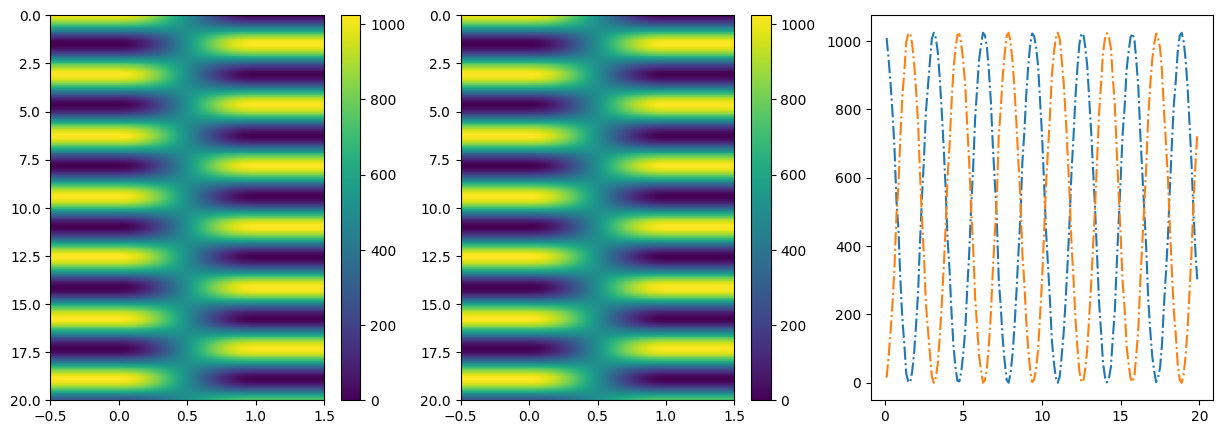

In [35]:
X, Y, Z = getStruturedData_grid(data, n_qubits)
x, y, z = getStruturedData_seq(data, n_qubits)


f, ax = plt.subplots(1, 3, figsize=(15, 5))
im0 = ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
f.colorbar(im0, ax=ax[0], orientation='vertical')

im1 = ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
f.colorbar(im1, ax=ax[1], orientation='vertical')

for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index[:20]],z[index[:20]], '-.')
plt.show()

## Exercise 3 - Transmission and Reflection Coefficient

We expect that when the transmission coefficient is 1, the rabi oscillation pulsation is 2g_o / hbar. Because this situation corresponds to a system where the electron cannot feel the separation between the two wells: the barrier is transparent. That value of the pulsation is explained by the coupling of the two states, leading to two hybridized states separated by an energy 2g_0.

So there must be a way to express T with g_0, probably using the analytical expression of T involving alpha, the decay parameter of the third wavefunction defined in the simple quantum well. We did not manage to obtain an analytical expression.

Nevertheless we see from our simulations that when g_0 =0, the electron is confined into one of the well : T=0. And so R=1.

By contrast, when g_0 = 10 for instance, which is the value of the diagonal elements, the Rabi Oscillation pulsation is also faster.



Number of wells: 2,
Number of levels: 1,
Number of qubits: 1,
Number of states: 2,
Hamiltonian:
 [[10.  0.]
 [ 0. 10.]]

Converted correctly to Operator: Yes


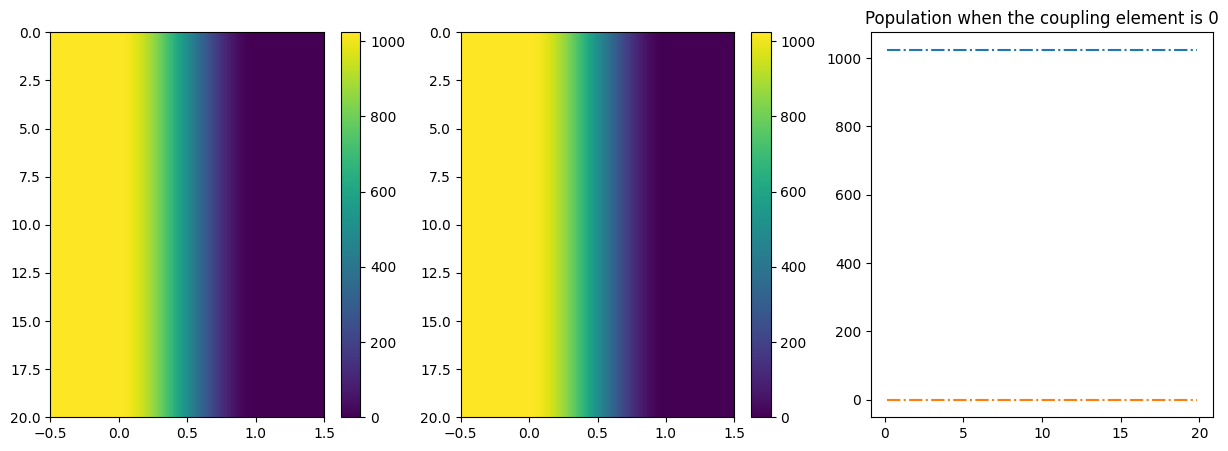

In [36]:
g0 = 0.
g0 = [[g0]]
h0 = [[10.0]]


data = W_model(Statevector(initial_state), n_levels, n_wells, h0, g0, t_max, dt, shots, noise = None)

X, Y, Z = getStruturedData_grid(data, n_qubits)
x, y, z = getStruturedData_seq(data, n_qubits)


f, ax = plt.subplots(1, 3, figsize=(15, 5))
im0 = ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
f.colorbar(im0, ax=ax[0], orientation='vertical')

im1 = ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
f.colorbar(im1, ax=ax[1], orientation='vertical')

for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index[:20]],z[index[:20]], '-.')
plt.title('Population when the coupling element is 0')
plt.show()


Number of wells: 2,
Number of levels: 1,
Number of qubits: 1,
Number of states: 2,
Hamiltonian:
 [[10. 10.]
 [10. 10.]]

Converted correctly to Operator: Yes


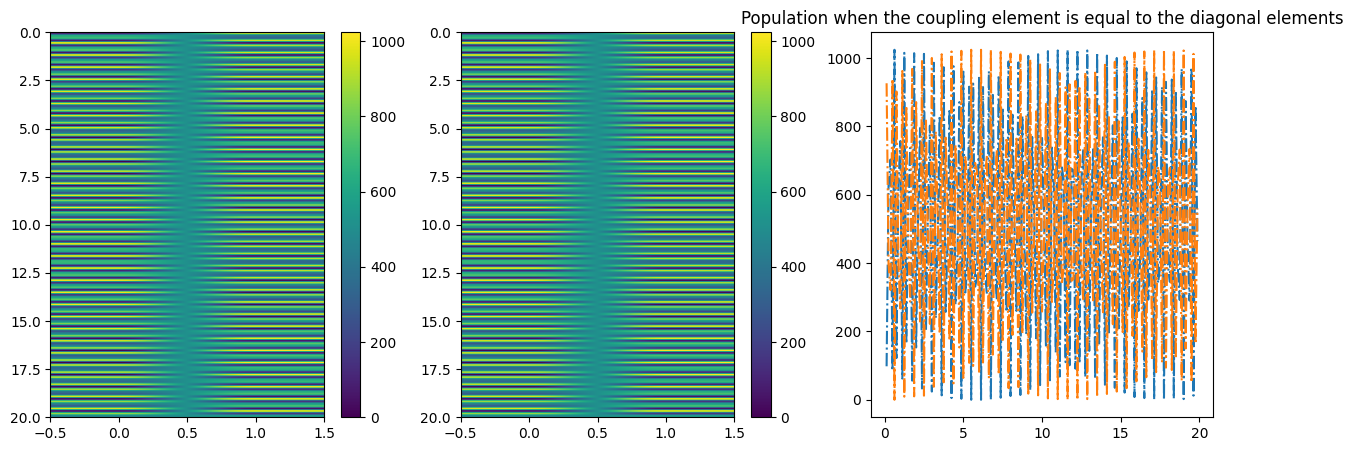

In [37]:
g0 = 10.0
g0 = [[g0]]
h0 = [[10.0]]


data = W_model(Statevector(initial_state), n_levels, n_wells, h0, g0, t_max, dt, shots, noise = None)

X, Y, Z = getStruturedData_grid(data, n_qubits)
x, y, z = getStruturedData_seq(data, n_qubits)


f, ax = plt.subplots(1, 3, figsize=(15, 5))
im0 = ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
f.colorbar(im0, ax=ax[0], orientation='vertical')

im1 = ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
f.colorbar(im1, ax=ax[1], orientation='vertical')

for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index[:20]],z[index[:20]], '-.')
plt.title('Population when the coupling element is equal to the diagonal elements')
plt.show()